# Abstract

This notebook is supplementary material to Stocker et al. "Towards research infrastructures that curate scienctific information: A use case in life sciences" originally submitted to the [13th International Conference on Data Integration in the Life Sciences](https://events.tib.eu/dils2018/) (DILS 2018), November 20-21, Hannover, Germany.

The notebook reproduces and proposes an alternative (and complementary) representation of a result published by [Haddad et al. (2017)](http://doi.org/10.1093/eurheartj/ehw333). Specifically, we reproduce the statistical hypothesis test underlying the statement "IRE binding activity was significantly reduced in failing hearts" using the data shown in Figure 1B (p. 364). 

In contrast to the conventional representation of a p-value, a plot and a natural language statement, we demonstrate how this results can be represented as a machine readable description for the statistical hypothesis test, specifically a two sample t-test with unequal variance with two continuous variables (and their corresponding values), the study design dependent variable, and the p-value.

In [ ]:
!pip install numpy pandas scipy rdflib matplotlib

In [ ]:
import io
import re
import requests
import numpy as np
import pandas as pd
from  urllib.parse import quote
from scipy.stats import ttest_ind
from rdflib import Graph, URIRef, BNode, Literal
from rdflib.namespace import RDF, XSD, RDFS
from rdflib.plugins.sparql.results.csvresults import CSVResultSerializer

In [1]:
obo = dict()

obo['STATO_0000304'] = URIRef('http://purl.obolibrary.org/obo/STATO_0000304')
obo['OBI_0000299'] = URIRef('http://purl.obolibrary.org/obo/OBI_0000299')
obo['OBI_0000175'] = URIRef('http://purl.obolibrary.org/obo/OBI_0000175')
obo['OBI_0000293'] = URIRef('http://purl.obolibrary.org/obo/OBI_0000293')
obo['STATO_0000251'] = URIRef('http://purl.obolibrary.org/obo/STATO_0000251')
obo['BFO_0000051'] = URIRef('http://purl.obolibrary.org/obo/BFO_0000051')
obo['IAO_0000032'] = URIRef('http://purl.obolibrary.org/obo/IAO_0000032')
obo['OBI_0001938'] = URIRef('http://purl.obolibrary.org/obo/OBI_0001938')
obo['OBI_0001933'] = URIRef('http://purl.obolibrary.org/obo/OBI_0001933')
obo['OBI_0001931'] = URIRef('http://purl.obolibrary.org/obo/OBI_0001931')
obo['OBI_0002135'] = URIRef('http://purl.obolibrary.org/obo/OBI_0002135')
obo['OBI_0001937'] = URIRef('http://purl.obolibrary.org/obo/OBI_0001937')
obo['OBI_0000751'] = URIRef('http://purl.obolibrary.org/obo/OBI_0000751')
obo['STATO_0000205'] = URIRef('http://purl.obolibrary.org/obo/STATO_0000205')
obo['STATO_0000019'] = URIRef('http://purl.obolibrary.org/obo/STATO_0000019')
obo['STATO_0000129'] = URIRef('http://purl.obolibrary.org/obo/STATO_0000129')
obo['GO_0030350'] = URIRef('http://purl.obolibrary.org/obo/GO_0030350')
obo['NCIT_C50577'] = URIRef('http://purl.obolibrary.org/obo/NCIT_C50577')
obo['NCIT_C25168'] = URIRef('http://purl.obolibrary.org/obo/NCIT_C25168')

api = 'http://localhost:8000/api/'

api_resources = '{}resources/'.format(api)
api_predicates = '{}predicates/'.format(api)
api_statements = '{}statements/'.format(api)

def create_ttest_description(df, tt):
    g = Graph()

    g.bind('obo', 'http://purl.obolibrary.org/obo/')
    g.bind('ex', 'http://example.org/')

    n1 = URIRef('http://example.org/n1')
    n2 = URIRef('http://example.org/n2')
    n3 = URIRef('http://example.org/n3')
    n4 = URIRef('http://example.org/n4')
    n5 = URIRef('http://example.org/n5')
    n6 = URIRef('http://example.org/n6')
    
    g.add((obo['STATO_0000304'], RDFS.label, Literal('two sample t-test with unequal variance')))
    g.add((obo['OBI_0000299'], RDFS.label, Literal('has specified output')))
    g.add((obo['OBI_0000293'], RDFS.label, Literal('has specified input')))
    g.add((obo['OBI_0000175'], RDFS.label, Literal('p-value')))
    g.add((obo['OBI_0001938'], RDFS.label, Literal('has value specification')))
    g.add((obo['OBI_0001931'], RDFS.label, Literal('scalar value specification')))
    g.add((obo['OBI_0001937'], RDFS.label, Literal('has specified numeric value')))
    g.add((obo['OBI_0000751'], RDFS.label, Literal('study design dependent variable')))
    g.add((obo['OBI_0001933'], RDFS.label, Literal('value specification')))
    g.add((obo['OBI_0002135'], RDFS.label, Literal('has specified value')))
    g.add((obo['GO_0030350'], RDFS.label, Literal('iron-responsive element binding')))
    g.add((obo['STATO_0000251'], RDFS.label, Literal('continuous variable')))
    g.add((obo['BFO_0000051'], RDFS.label, Literal('has part')))
    g.add((obo['IAO_0000032'], RDFS.label, Literal('scalar measurement datum')))
    g.add((obo['STATO_0000129'], RDFS.label, Literal('has value')))
    g.add((obo['STATO_0000019'], RDFS.label, Literal('normal distribution hypothesis')))
    g.add((obo['STATO_0000205'], RDFS.label, Literal('is denoted by')))
    g.add((obo['NCIT_C50577'], RDFS.label, Literal('heart failure')))
    g.add((obo['NCIT_C25168'], RDFS.label, Literal('tissue donor')))

    g.add((n1, RDF.type, obo['STATO_0000304']))
    g.add((n1, obo['OBI_0000299'], n2))
    g.add((n2, RDF.type, obo['OBI_0000175']))
    g.add((n2, obo['OBI_0001938'], n3))
    g.add((n3, RDF.type, obo['OBI_0001931']))
    g.add((n3, obo['OBI_0001937'], Literal(tt.pvalue, datatype=XSD.double)))
    g.add((n1, obo['OBI_0000293'], n4))
    g.add((n4, RDF.type, obo['OBI_0000751']))
    g.add((n4, RDF.type, obo['GO_0030350']))
    
    for c in list(df):
        b1 = BNode()
        g.add((n1, obo['OBI_0000293'], b1))
        g.add((b1, RDF.type, obo['STATO_0000251']))
        for v in df[c]:
            if np.isnan(v): 
                continue
            b2 = BNode()
            b3 = BNode()
            g.add((b1, RDFS.label, Literal(c)))
            g.add((b1, obo['BFO_0000051'], b2))
            g.add((b2, RDF.type, obo['IAO_0000032']))
            g.add((b2, obo['OBI_0001938'], b3))
            g.add((b3, RDF.type, obo['OBI_0001931']))
            g.add((b3, obo['OBI_0001937'], Literal(str(v), datatype=XSD.double)))

    return g

def query(g, q):
    serializer = CSVResultSerializer(g.query(q))
    output = io.BytesIO()
    serializer.serialize(output)
    return pd.read_csv(io.StringIO(output.getvalue().decode('utf-8')))

def store(g):
    for s, p, o in g:
        store_statement(s, p, o)
        
def read():
    g = Graph()
    res = requests.get(api_statements)
    json = res.json()
    for stmt in json:
        s = get_uri(get_label('{}{}'.format(api_resources, stmt['subject'])))
        p = get_uri(get_label('{}{}'.format(api_predicates, stmt['predicate'])))
        if stmt['object']['type'] == 'resource':
            o = get_uri(get_label('{}{}'.format(api_resources, stmt['object']['id'])))
        else:
            v = stmt['object']['value']
            try:
                o = Literal(float(stmt['object']['value']), datatype=XSD.double)
            except ValueError:
                o = Literal(stmt['object']['value'])
        if s == False or p == False or o == False:
            continue
        g.add((s, p, o))
    return g
    
def store_statement(s, p, o):
    s_id = get_id(api_resources, s)
    p_id = get_id(api_predicates, p)
    
    if type(o) is Literal:
        o_v = o.toPython()
        res = requests.post('{}{}/{}'.format(api_statements, s_id, p_id), json={'value':o_v,'type':'literal'}, headers={'Content-Type':'application/json'})
        return res.json()['statementId']
    
    o_id = get_id(api_resources, o)
    
    res = requests.post('{}{}/{}/{}'.format(api_statements, s_id, p_id, o_id), headers={'Content-Type':'application/json'})
    return res.json()['statementId']
    
def get_id(api, r):
    r = r.toPython()
    res = requests.get(api, params={'q':r}, headers={'Content-Type':'application/json', 'Accept':'application/json'})
    resj = res.json()
    
    if len(resj) == 0:
        res = requests.post(api, json={'label':r}, headers={'Content-Type':'application/json'})
        return res.json()['id']
        
    if len(resj) == 1:
        return resj[0]['id']
        
    raise Exception('Lookup, expected only one result [{}]'.format(resj))
    
def get_label(api):
    res = requests.get(api, headers={'Content-Type':'application/json', 'Accept':'application/json'})
    return res.json()['label']

def get_uri(s): 
    if s.startswith('http://'):
        return URIRef(s)
    if re.match('N([0-9][a-z])*', s):
        return BNode(s)
    return False

## Statistical hypothesis test

We first perform the statistical hypothesis test. This step is shared with the conventional approach, except that in practice researchers use [Prism](https://www.graphpad.com/scientific-software/prism/). We obtain the p-value.

In [2]:
labels = ['non-failing heart (NF)', 'failing heart (F)']
data = [(99, 52), (96, 40), (100, 38), (105, 18), 
        (np.nan, 11), (np.nan, 5), (np.nan, 42), 
        (np.nan, 55), (np.nan, 53), (np.nan, 39),
        (np.nan, 42), (np.nan, 50)]

df = pd.DataFrame.from_records(data, columns=labels)
tt = ttest_ind(df['non-failing heart (NF)'], 
               df['failing heart (F)'], 
               equal_var=False, nan_policy='omit')

tt.pvalue

1.3111247517411591e-08

Here is where the proposed approach diverges from the conventional one. We suggest to use the [STATO](http://stato-ontology.org/) general purpose statistics ontology, the [Ontology for Biomedical Investigations](http://obi-ontology.org/) (OBI), the [Information Artifact Ontology](http://www.obofoundry.org/ontology/iao.html) (IAO), and the [Gene Ontology](http://www.geneontology.org/) (GO) (among others) to create a machine readable semantic description of the statistical hypothesis test.

In [3]:
g = create_ttest_description(df, tt)

We can look at the resulting RDF graph.

In [4]:
print(g.serialize(format='turtle').decode('utf-8'))

@prefix ex: <http://example.org/> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ex:n1 a obo:STATO_0000304 ;
    obo:OBI_0000293 [ a obo:STATO_0000251 ;
            rdfs:label "failing heart (F)" ;
            obo:BFO_0000051 [ a obo:IAO_0000032 ;
                    obo:OBI_0001938 [ a obo:OBI_0001931 ;
                            obo:OBI_0001937 1.1e+01 ] ],
                [ a obo:IAO_0000032 ;
                    obo:OBI_0001938 [ a obo:OBI_0001931 ;
                            obo:OBI_0001937 4.2e+01 ] ],
                [ a obo:IAO_0000032 ;
                    obo:OBI_0001938 [ a obo:OBI_0001931 ;
                            obo:OBI_0001937 1.8e+01 ] ],
                [ a obo:IAO_0000032 ;
                    obo:OBI_0001938 [ a obo:OBI_0001931 ;
        

We can also store the graph. In our preliminary experiments, we are developing a graph database that builds on [Neo4j](https://neo4j.com/). This database has not been released at the time of publishing this notebook. Hence, isn't possible for you to actually store the graph as implemented here. However, the code provides some useful details.

In [5]:
# store(g)

We can read RDF from the database. This code is here for reference.

In [6]:
# g = read()

Given RDF, we can execute SPARQL queries. The following query is for two sample t-tests with unequal variance with iron-responsive element binding as dependent variable and p-value < 0.005). The second query extracts the data of the two variables, creates a data frame and plots the data.

In [7]:
display(query(g, """
PREFIX obo: <http://purl.obolibrary.org/obo/>
SELECT ?test ?pvalue WHERE {
 ?test a obo:STATO_0000304 ;                        # a two sample t-test with unequal variance
    obo:OBI_0000299 [                               # that has specified output
        a obo:OBI_0000175 ;                         # a p-value
        obo:OBI_0001938 [                           # that has value specification
            a obo:OBI_0001931 ;                     # a scalar value specification
            obo:OBI_0001937 ?pvalue                 # that has specified numeric value ?pvalue
        ] 
    ] .
 ?test obo:OBI_0000293 [                            # and has specified input
    a obo:OBI_0000751, obo:GO_0030350 ;             # a study design dependent variable, iron-responsive element binding
 ] . 
 FILTER (?pvalue < 0.005)
}
"""))

,test,pvalue
0,http://example.org/n1,1.311125e-08


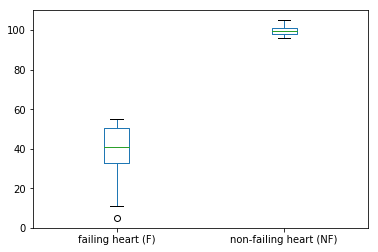

In [8]:
%matplotlib inline

df = query(g, """
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX ex: <http://example.org/>
SELECT ?variable ?value WHERE {
 ex:n1 a obo:STATO_0000304 .                # the two sample t-test with unequal variance
 ex:n1 obo:OBI_0000293 ?v .                 # that has specified input
 ?v a obo:STATO_0000251 .                   # a continuous variable
 ?v rdfs:label ?variable .                  # with label
 ?v obo:BFO_0000051 [                       # that has part
    a obo:IAO_0000032 ;                     # a scalar measurement datum
    obo:OBI_0001938 [                       # that has value specification
        a obo:OBI_0001931 ;                 # a scalar value specification
        obo:OBI_0001937 ?value              # that has specified numeric value
    ]
 ]
}
ORDER BY (?variable)
""")

df.pivot(columns='variable', values='value').plot.box()